# Model - Bootstrap

> ### Imports

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from iqual import iqualnlp, evaluation, crossval

> ### Load `annotated (human-coded)` and `unannotated` datasets

In [2]:
data_dir         = "../../data"
human_coded_df   = pd.read_csv(os.path.join(data_dir,"annotated.csv"))
uncoded_df       = pd.read_csv(os.path.join(data_dir,"unannotated.csv"))

> ### Configure training data

In [3]:
### Select Question and Answer Columns
question_col = 'Q_en'
answer_col   = 'A_en'

### Select a code
code_variables = ['religious', 'secular', 'no_ambition', 'vague_job',
                  'job_secular','vocational_training', 'entrepreneur',
                  'education_low','education_neutral', 'education_high',
                  'education_religious', 'marriage', 'migration',
                  'vague_non_specific', 'reliance_on_god', 'ability_high',
                  'ability_low', 'budget_high', 'budget_low',
                  'awareness_information_high','awareness_information_low',
                  'camp_regulations', 'covid_impacts', 'public_assistance',
                  'worries_anxieties',
                 ]

In [4]:
# Scorig Dict for evaluation
scoring_dict = evaluation.get_scoring_dict(['f1'])

> ### Configure a Hyperparameter Grid for cross-validation + fitting

In [5]:
## Paths for precomputed vectors created using `sentence-transformers`
dict_dir          = "../dictionaries"

### Sentence-Transformers precomputed vectors
sbert_models      = ["all-mpnet-base-v2",'all-roberta-large-v1',"distiluse-base-multilingual-cased-v2"]
sbert_model_paths = [os.path.join(dict_dir,m+'.pkl') for m in sbert_models]

### Spacy precomputed vectors
spacy_models      = ["en_core_web_sm"]
spacy_model_paths = [os.path.join(dict_dir,m+'.pkl') for m in spacy_models]

### All precomputed vectors
model_paths = [*sbert_model_paths,*spacy_model_paths]

In [6]:
PRETRAINED_QA_PARAMS = {
    "Input":{"question":{"vectorizer":{"model":model_paths,"env":['saved-dictionary']}},"answer":{"vectorizer":{"model":model_paths,"env":['saved-dictionary']}}},
}
PRETRAINED_A_PARAMS = {
    "Input":{"question":["drop"],"answer":{"vectorizer":{"model":model_paths,"env":['saved-dictionary']}}},
}
SKLEARN_QA_PARAMS  = {
    "Input":{
        "question":{"vectorizer":{"model":['TfidfVectorizer','CountVectorizer'],"env":['scikit-learn'],'max_features':np.arange(1000,6500,1000)}},
        "answer":{"vectorizer":{"model":['TfidfVectorizer','CountVectorizer'],"env":['scikit-learn'],'max_features':np.arange(1500,8500,500)}}
    },    
}
SKLEARN_A_PARAMS  = {
    "Input":{
        "question":["drop"],
        "answer":{"vectorizer":{"model":['TfidfVectorizer','CountVectorizer'],"env":['scikit-learn'],'max_features':np.arange(1500,8500,1000)}}
    },    
}
LOGISTIC_PARAMS      = {"Classifier":{"model":["LogisticRegression"],"C":[0.001,0.01,0.1,0.1,1,10],'penalty':['l1','l2'],'solver':['saga']}}
RANDOM_FOREST_PARAMS = {"Classifier":{"model":["RandomForestClassifier"],"n_estimators":[100,200,400],'max_depth':[5,10,25]}}
SGD_PARAMS           = {"Classifier":{"model":["SGDClassifier"],"loss":["modified_huber"],"penalty":["l2","l1"]}}
SVC_PARAMS           = {"Classifier":{"model":["SVC"],"C":[0.001,0.01,0.1,0.1,1,10],'kernel':['linear','rbf']}}
KNN_PARAMS           = {"Classifier":{"model":["KNeighborsClassifier"],"n_neighbors":[5,10,15,25],'weights':['uniform'],}}

VECTORIZATION_PARAMS   = [PRETRAINED_QA_PARAMS,PRETRAINED_A_PARAMS,SKLEARN_QA_PARAMS,SKLEARN_A_PARAMS]
CLASSIFIER_PARAMS      = [LOGISTIC_PARAMS,RANDOM_FOREST_PARAMS,SGD_PARAMS,SVC_PARAMS,KNN_PARAMS]
ALL_PARAM_COMBINATIONS = [{**vect_params, **clf_params} for vect_params in VECTORIZATION_PARAMS for clf_params in CLASSIFIER_PARAMS]

CV_SEARCH_PARAMS = [crossval.convert_nested_params(p) for p in ALL_PARAM_COMBINATIONS]
print(f"Number of hyperparameter configurations: {crossval.count_hyperparameters(CV_SEARCH_PARAMS)}")

Number of hyperparameter configurations: 1014


> ## Model training:
> Cross-validate over hyperparameters and select the best model

In [7]:
NUM_BOOTSTRAP_RUNS = 25

In [ ]:
bootstrap_dfs = []
cv_dfs        = []
param_dfs     = []

for bootstrap_run in range(1,NUM_BOOTSTRAP_RUNS+1,1):
    
    
    train_df, test_df   = train_test_split(human_coded_df,test_size=0.25)
    
    train_df['split']   = 'train'
    test_df['split']    = 'test'
    uncoded_df['split'] = 'unannotated'
    
    boot_df = pd.concat([train_df,test_df,uncoded_df])
    boot_df['bootstrap_run'] = bootstrap_run
    
    for code_var in code_variables:
        
        print(f"Bootstrap {bootstrap_run} | Annotation: {code_var}")
        
        ## Create X and y
        X = train_df[[question_col,answer_col]]
        y = train_df[code_var]

        iqual_model = iqualnlp.Model()
        iqual_model.add_text_features(question_col,answer_col)
        iqual_model.add_classifier()
        iqual_model.add_threshold()
        iqual_model.compile()
        
        cv_dict = iqual_model.cross_validate_fit(
            X,y,                                # X: Pandas DataFrame of features, y: Pandas Series of labels
            search_parameters=CV_SEARCH_PARAMS, # search_parameters: Dictionary of parameters to use for cross-validation
            cv_method='GridSearchCV',     # cv_method: Cross-validation method to use, options: GridSearchCV, RandomizedSearchCV
            # n_iter=5,                           # n_iter: Only when cv_method='RandomizedSearchCV'
            scoring=scoring_dict,               # scoring: Scoring metric to use for cross-validation    
            refit='f1',                         # refit: Metric to use for refitting the model
            n_jobs=-1,                          # n_jobs: Number of parallel threads to use  
            cv_splits=3,                        # cv_splits: Number of cross-validation splits
        )
        
        
        ## Selected Best parameters
        selected_param_df = pd.DataFrame.from_dict(iqual_model.cv.get_best_params(),orient='index').T
        selected_param_df['annotation']    = code_var
        selected_param_df['bootstrap_run'] = bootstrap_run        
        param_dfs.append(selected_param_df)
        
        # `NOTE`: Use `iqual_model.cv.get_cv_results()` to get more detailed cross-validation results.
        
        ## Cross-Validation data
        print("\n\nAverage F1 score for {code_var}: {score:.3f}".format(code_var=code_var,score=cv_dict['avg_test_score']),end='\n\n')
        
        cv_df = pd.DataFrame([cv_dict])
        cv_df['annotation']    = code_var
        cv_df['bootstrap_run'] = bootstrap_run
        cv_dfs.append(cv_df)

        
        # Predict on both `test` (held-out human annotated data) and on (uncoded/machine data) using the dataframe:
        boot_df[code_var+"_pred"]  = iqual_model.predict(boot_df[['Q_en','A_en']])        
    
    # Append after each bootstrap run
    bootstrap_dfs.append(boot_df)

param_data     = pd.concat(param_dfs)    
bootstrap_data = pd.concat(bootstrap_dfs,axis=0)

> ## Selected model parameters

In [877]:
param_data     = pd.concat(param_dfs)    

# Best Parameters
param_data = param_data[['annotation','bootstrap_run','Input__question__vectorizer__model','Input__answer__vectorizer__model','Classifier__model']]

# Question: Drop | Keep
param_data.loc[param_data['Input__question__vectorizer__model'].isna(),'question']  = 'Answer only'
param_data.loc[param_data['Input__question__vectorizer__model'].notna(),'question'] = 'Question + Answer'

# Rename columns
param_data = param_data.rename(columns={'Input__answer__vectorizer__model':'vectorization','Classifier__model':'classifier'})

# Replace Dictionary paths of precomputed pkl files 
param_data['vectorization'] = param_data['vectorization'].apply(lambda x: os.path.basename(x).replace('.pkl',''))
param_data = param_data[['annotation','bootstrap_run','question','vectorization','classifier']]

In [216]:
question_options      = param_data['question'].unique()
vectorizer_options    = param_data['vectorization'].unique()
classifier_options    = param_data['classifier'].unique()
all_options = [*question_options,*vectorizer_options,*classifier_options]

colors = [
    '#00425A','#A4BE7B',
    '#9C2C77','#CD104D','#E14D2A','#FD841F','#FFD384',
    '#0C084C','#096386','#00B7A8', '#544179', '#BFEAF5',
]

color_dict = {option:colors[o] for o, option in enumerate(all_options)}

> ## Plot `parameter selections` for each annotation across: 
>
- Question/ Question + Answer

- Vectorizer

- Classifier

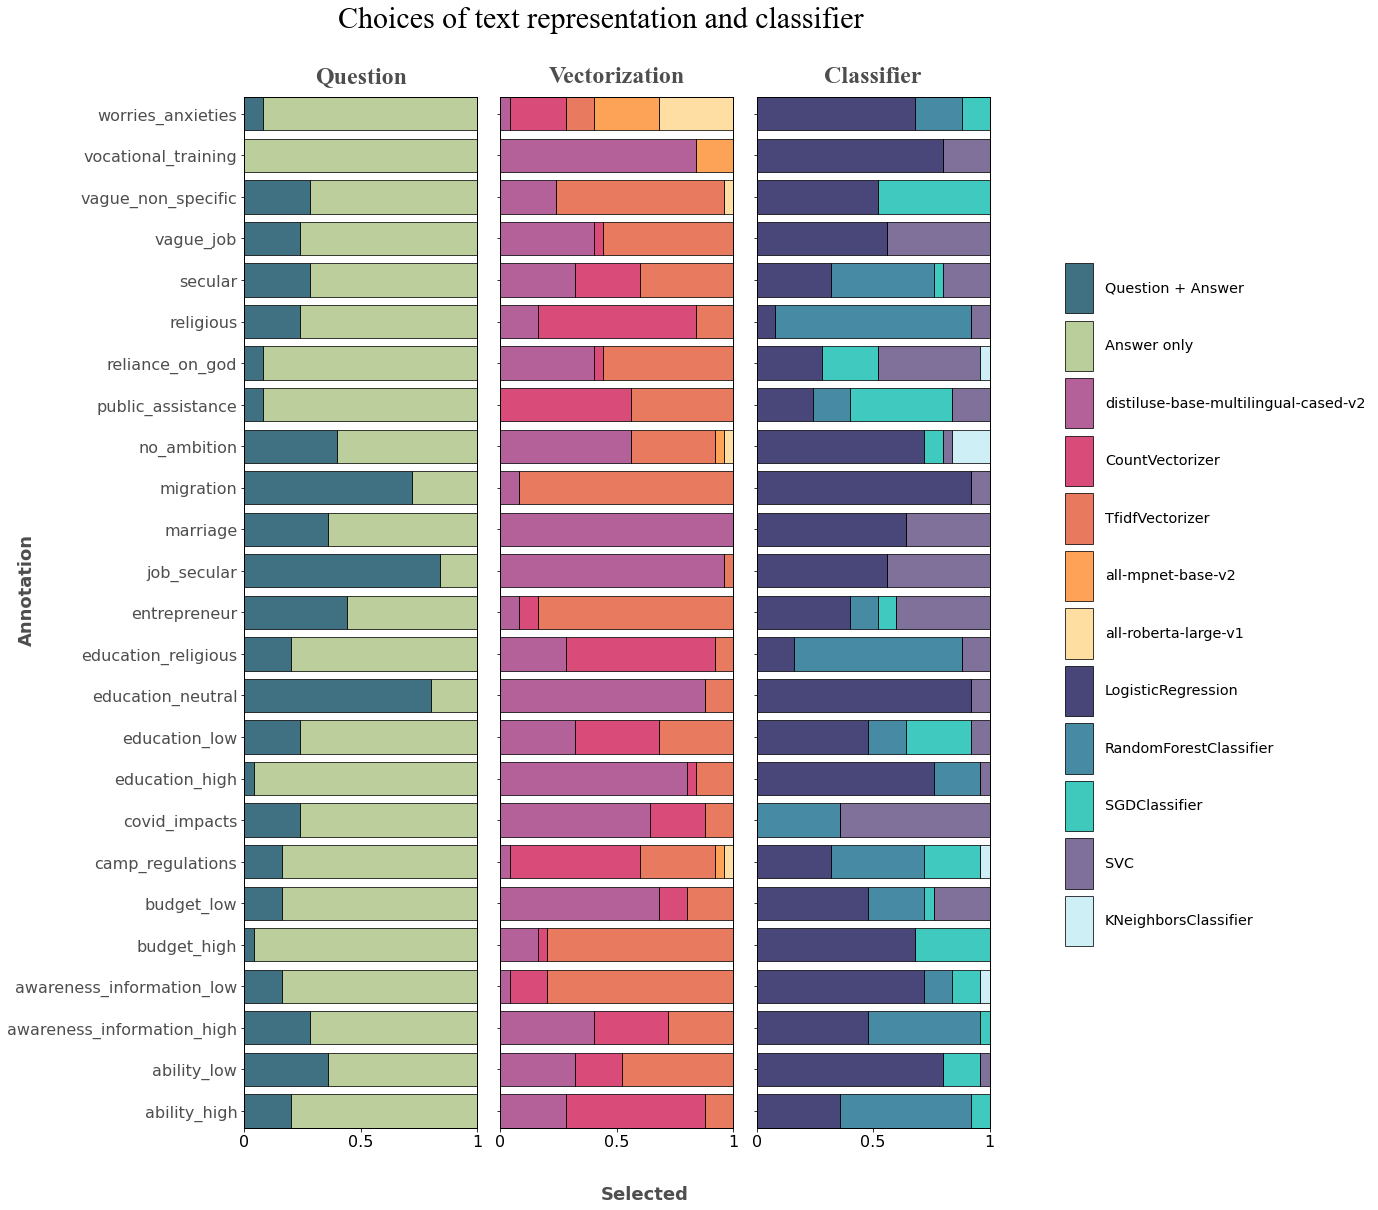

In [217]:
import matplotlib.pyplot as plt
import numpy as np

# Subplots
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(18,18))

# Title
fig.suptitle("Choices of text representation and classifier",x=0.4, y=0.99, fontfamily='Times New Roman',fontsize=30,)

# Empty lists - handles/labels for adding common legend later.
handles = []
labels  = []

for i, (ax, col) in enumerate(zip(axs, ['question', 'vectorization', 'classifier'])):
    param_df = param_data.groupby('annotation')[col].value_counts().unstack().fillna(0) / param_data.bootstrap_run.nunique()
    bottom   = np.zeros(len(param_df.index))
    
    for j, key in enumerate(param_data[col].unique()):
        values = param_df[key].values
        h      = ax.barh(param_df.index, 
                         values, 
                         color=color_dict[key], 
                         alpha=0.75,ec='k',lw=1, 
                         left=bottom
                        )
        
        bottom += values
        
        handles.append(h)
        labels.append(key)      
    
    ax.grid(False)
    ax.margins(0, 0, tight=True)
    
    ax.set_title(col.capitalize(),fontdict={'family':'Times New Roman',
                                            'fontsize':24,
                                            'color':'#4e4e4e',
                                            'fontweight':800
                                           },
                 pad=15)    
    
    # Optional: Create a line at the boundary of each subplot
    for pos in ['top','right','bottom','left']:
        ax.spines[pos].set(lw=1,ec='k') 
                
    # X-axis
    ax.set_xticks([0,0.5,1],labels=[0,0.5,1], fontsize=16, fontweight='light')
    
    # Y-axis
    ax.tick_params(axis='y',labelsize=16, labelcolor='#4e4e4e')

# X-axis label
fig.text(0.4, 0.07, 'Selected',fontdict={"fontsize":18,
                                         'color':"#4e4e4e",
                                         'weight':'bold'},)

# Y-axis label
fig.text(-0.05, 0.5,'Annotation',rotation='vertical',fontdict={"fontsize":18,
                                                               'color':"#4e4e4e",
                                                               'weight':'bold'},
        )

# Legend
fig.legend(handles, labels, ncol=1, loc='center right', 
           frameon=False, labelspacing=0.5, 
           handlelength=2,handleheight=5,
           fontsize='x-large')

# Plot
plt.subplots_adjust(top=0.92,wspace=0.1,right=0.7)
plt.show()

In [71]:
### F1 score using random predictions --> sparsity of variable
random_f1_dict = dict(human_coded_df[code_variables].mean())

> ### Plot `Validation set performance`

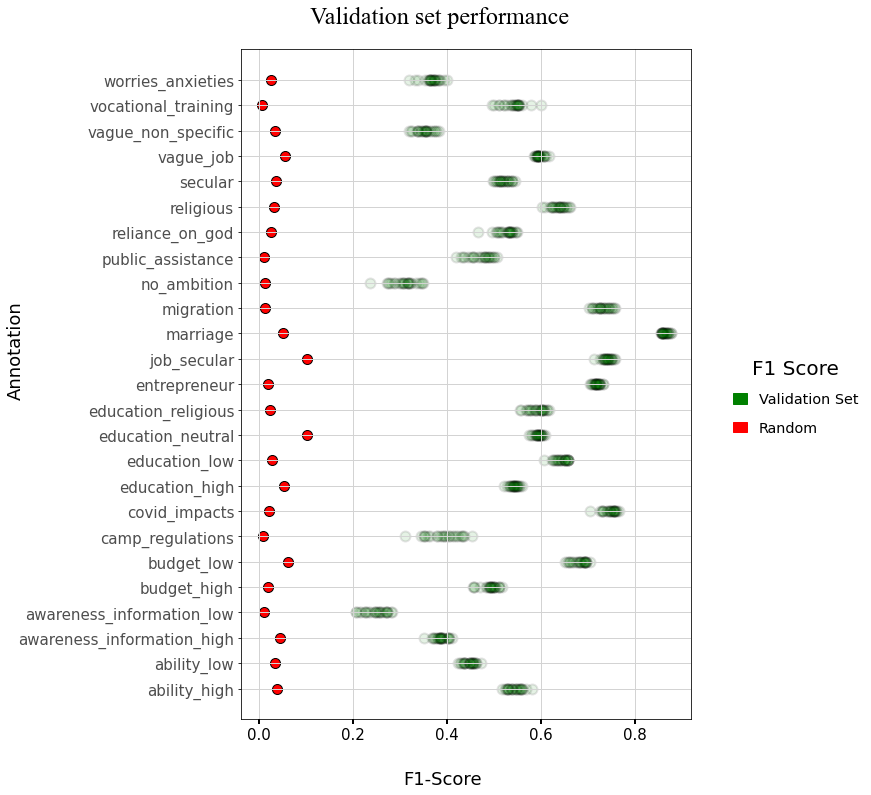

In [215]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(10,12))

# Title
fig.suptitle("Validation set performance", x=0.4, y=0.95, fontfamily='Times New Roman',fontsize=24,)

# X-axis
ax.scatter(y=cv_df['annotation'],
           x=cv_df['mean_test_f1'],
           marker='o', s=100, ec='k',lw=2,color='g', alpha=0.1,
           label='Validation Set'
           
          )
ax.scatter(y=list(random_f1_dict.keys()),
           x=list(random_f1_dict.values()),
           marker='o',s=100,ec='k',lw=1,color='r',alpha=1,
           label='Random'
          )

# Y-axis
ax.set_yticks(cv_df['annotation'].unique())
ax.set_yticklabels(cv_df['annotation'].unique(), fontsize=16, fontweight='light')
ax.grid(True, lw=1, c='lightgray')

# X-axis
ax.tick_params(axis='x',labelsize=15, length=5, width=2)
# Y-axis
ax.tick_params(axis='y',labelsize=15, labelcolor='#4e4e4e')

# X-axis label
fig.text(0.35, 0.05, "F1-Score",fontsize=18)
# Y-axis label
fig.text(-0.2, 0.5,'Annotation',rotation='vertical',fontsize=18)

# Legend
patches = [
    mpatches.Patch(color='green', label='Validation Set'),
    mpatches.Patch(color='red', label='Random'),    
          ]

fig.legend(handles=patches, 
          title='F1 Score',
          title_fontsize=20,
          ncol=1,labelspacing=1,handlelength=1,
          loc='center right',frameon=False,
          fontsize='x-large',
         )

# Figure
plt.subplots_adjust(top=0.9,right=0.75)
plt.show()